<div align="center">
  <h1>АДЭФС. Лабораторная работа №2</h1>
</div>

<div align="center">
  <h2>Отчет о выполнении</h2>
</div>

<div align="right">
  <h3>Студента 3 курса 8 группы</h3>
</div>

<div align="right">
  <h3>Петрачкова Г.А.</h3>
</div>

# Анализ целесообразности проведения факторного анализа

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

df = pd.read_csv("Annual 2005-2011.csv")
df_cens = df.copy()
df_cens = df_cens.drop(columns=[df_cens.columns[0]])
df_cens = df_cens.drop(columns=[df_cens.columns[-1]])
df_cens = df_cens.drop(columns=[df_cens.columns[7]])

_, kmo_model = calculate_kmo(df_cens)
chi_square_value, p_value = calculate_bartlett_sphericity(df_cens)

results = pd.DataFrame({
    'Показатель': [
        'Статистика Кайзера–Мейера–Олкина',
        'Критерий сферичности Бартлетта',
        'Статистика χ²',
        'p-значение'
    ],
    'Значение': [
        round(kmo_model, 3),
        '',
        round(chi_square_value, 3),
        f"{p_value:.3f}"
    ]
})
results

,Показатель,Значение
0,Статистика Кайзера–Мейера–Олкина,0.724
1,Критерий сферичности Бартлетта,
2,Статистика χ²,26536.332
3,p-значение,0.000


В соответствии с таблицей выше, нулевая гипотеза о том, что корреляционная матрица 
является единичной, отклоняется критерием сферичности Бартлетта. Приближенное 
значение статистики равно 26536.332, она является значимой на уровне 0,05. Значение 
статистики КМО, равное 0.724, свидетельствует о приемлемом качестве выборки для 
применения факторного анализа (пороговым в данном случае обычно считается значение 
0,6). Следовательно, использование факторного анализа применительно к данной выборке 
является целесообразным.

# Метод главных компонент

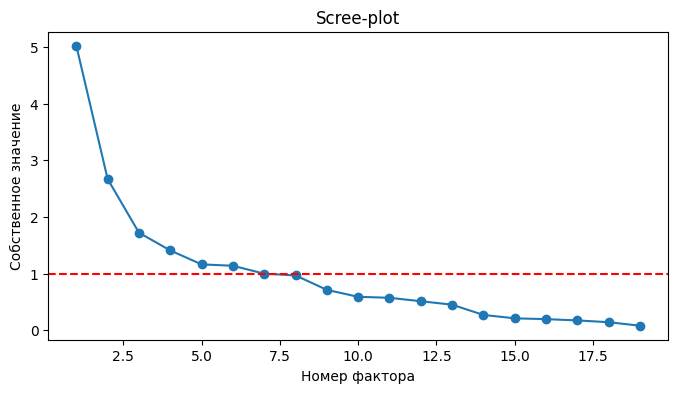

C:\Users\chest\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\chest\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Выбрано факторов: 6 (Kaiser: 6, Parallel: 6)


,№ фактора,Собственные значения (до вращ.),% объясненной дисперсии (до вращ.),Кумулятивный % (до вращ.),Собственные значения (после вращ.),% объясненной дисперсии (после вращ.),Кумулятивный % (после вращ.)
0,1.,5.021,25.011,25.011,3.207,16.879,16.879
1,2.,2.669,12.269,37.280,3.067,16.144,33.023
2,3.,1.721,7.766,45.046,1.544,8.126,41.149
3,4.,1.408,4.924,49.970,1.278,6.729,47.878
4,5.,1.163,4.679,54.649,1.197,6.300,54.178
5,6.,1.138,3.823,58.472,0.816,4.293,58.472


In [2]:
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

X = df_cens.copy()
X = StandardScaler().fit_transform(X)
n, m = X.shape

R = np.corrcoef(X, rowvar=False)
eigvals = np.linalg.eigvalsh(R)[::-1]

plt.figure(figsize=(8, 4))
plt.plot(range(1, m+1), eigvals, marker='o')
plt.axhline(1, color='red', linestyle='--')
plt.title("Scree-plot")
plt.xlabel("Номер фактора")
plt.ylabel("Собственное значение")
plt.show()

kaiser = np.sum(eigvals > 1)

rng = np.random.default_rng(42)
rand_eigvals = np.zeros((500, m))
for i in range(500):
    rand = rng.normal(size=(n, m))
    rand = (rand - rand.mean(axis=0)) / rand.std(axis=0, ddof=0)
    Rr = np.corrcoef(rand, rowvar=False)
    rand_eigvals[i] = np.linalg.eigvalsh(Rr)[::-1]
porog = np.percentile(rand_eigvals, 95, axis=0)
parallel = np.sum(eigvals > porog)

n_factors = max(kaiser, parallel)

fa = FactorAnalyzer(n_factors=n_factors, rotation=None)
fa.fit(X)
loadings_no_rot = fa.loadings_
eigvals_no_rot = np.sum(loadings_no_rot**2, axis=0)

fa_rot = FactorAnalyzer(n_factors=n_factors, rotation="quartimax")
fa_rot.fit(X)
loadings_rot = fa_rot.loadings_
eigvals_rot = np.sum(loadings_rot**2, axis=0)

dod = eigvals_no_rot / m * 100
cum_dod = np.cumsum(dod)
dod_rot = eigvals_rot / m * 100
cum_dod_rot = np.cumsum(dod_rot)

table = pd.DataFrame({
    "№ фактора": [f"{i+1}." for i in range(n_factors)],
    "Собственные значения (до вращ.)": eigvals[:n_factors].round(3),
    "% объясненной дисперсии (до вращ.)": dod.round(3),
    "Кумулятивный % (до вращ.)": cum_dod.round(3),
    "Собственные значения (после вращ.)": eigvals_rot.round(3),
    "% объясненной дисперсии (после вращ.)": dod_rot.round(3),
    "Кумулятивный % (после вращ.)": cum_dod_rot.round(3)
})

print(f"\nВыбрано факторов: {n_factors} (Kaiser: {n_kaiser}, Parallel: {n_parallel})")
table

Согласно таблице выше, в совокупности выделенные факторы объясняют 58,472% 
дисперсии исходных показателей, в частности, первый фактор до вращения объясняет 
25,011%  дисперсии, второй – 12,269%, третий – 7,766%, четвертый – 4,924%, пятый – 
4,679%, шестой - 3,823%. Вращение факторов (квартимакс) приводит к более равномерному 
распределению объясненной дисперсии между факторами и к увеличению удельного 
веса каждого из них (за исключением первого фактора). Таким образом, на долю 
первого фактора после вращения приходится 16,879% объясненной дисперсии, второго – 
16,144%, третьего – 8,126%, четвертого – 6,729%, пятого –  6,300%, шестого - 4,293%.

# Анализ факторных нагрузок

In [3]:
variable_names = df_cens.columns

table_no_rot = pd.DataFrame(loadings_no_rot, index=variable_names, columns=[f"F{i+1}" for i in range(n_factors)])
table_no_rot = table_no_rot.round(3)

table_rot = pd.DataFrame(loadings_rot, index=variable_names, columns=[f"F{i+1}" for i in range(n_factors)])
table_rot = table_rot.round(3)

print("\nТАБЛИЦА ФАКТОРНЫХ НАГРУЗОК ДО ВРАЩЕНИЯ:")
table_no_rot


ТАБЛИЦА ФАКТОРНЫХ НАГРУЗОК ДО ВРАЩЕНИЯ:


,F1,F2,F3,F4,F5,F6
k1,0.781,-0.395,-0.176,0.069,0.220,-0.058
k2,0.661,-0.289,-0.124,0.027,0.385,-0.096
k3,0.794,-0.363,-0.302,0.058,0.280,-0.073
k4,0.635,0.038,0.093,-0.041,-0.227,-0.369
k5,-0.537,0.431,-0.468,0.396,0.331,0.201
k6,-0.253,-0.183,-0.032,0.049,-0.059,-0.185
k7,-0.421,-0.154,-0.088,-0.021,0.003,-0.155
k9,0.465,-0.568,0.008,-0.076,-0.108,0.241
k10,0.155,0.469,-0.329,0.189,0.157,-0.226
k11,0.125,0.229,-0.029,-0.221,0.079,0.238


In [4]:
print("\nТАБЛИЦА ФАКТОРНЫХ НАГРУЗОК ПОСЛЕ ВРАЩЕНИЯ:")
table_rot


ТАБЛИЦА ФАКТОРНЫХ НАГРУЗОК ПОСЛЕ ВРАЩЕНИЯ:


,F1,F2,F3,F4,F5,F6
k1,0.894,0.112,-0.153,-0.026,0.129,-0.021
k2,0.814,0.134,-0.047,0.099,-0.028,0.006
k3,0.951,0.134,-0.062,-0.098,0.070,-0.001
k4,0.338,0.471,-0.402,-0.095,0.064,-0.304
k5,-0.288,-0.113,0.943,-0.107,-0.050,0.037
k6,-0.092,-0.271,-0.029,-0.060,-0.121,-0.193
k7,-0.192,-0.348,0.056,-0.079,-0.232,-0.112
k9,0.520,-0.194,-0.409,-0.052,0.313,0.198
k10,0.090,0.424,0.437,-0.170,-0.118,-0.206
k11,-0.013,0.246,0.044,-0.003,-0.005,0.344


Для интерпретации факторов используется анализ факторных нагрузок до и после 
вращения факторов, приведенные для используемой выборки в таблицах выше.
Таблицы содержат элементы, которые представляют собой коэффициенты 
корреляции для отдельных показателей и построенных факторов. Как видно из первой таблицы, наиболее тесная 
корреляция с первой главной компонентой, сохраняющей наибольший процент дисперсии исходных показателей, существует со следующими коэффициентами: k1, 
k2, k3, k9.
После применения процедуры вращения с первой главной компонентой наиболее 
тесно коррелируют показатели ликвидности (k1, k2, k3). Со второй компонентой – коэффициенты рентабельности (k18, k19, k20). С третьей компонентой – коэффициенты финансовой устойчивости (k4, k5, k9, k10). С четвертой – коэффициенты деловой активности (k15, k16). С пятой - также коэффициенты деловой активности (k13, k14).

# Расчет интегрального показателя кредитоспособности

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
explained_var_ratio = pca.explained_variance_ratio_
weights = explained_var_ratio[:X_pca.shape[1]]
credit_score = np.dot(X_pca, weights)
result_df = pd.DataFrame(credit_score, columns=["Индекс кредитоспособности"])
result_df

,Индекс кредитоспособности
0,-0.257691
1,0.331032
2,-0.864104
3,2.067032
4,-0.095803
...,...
2690,0.194824
2691,0.200809
2692,0.284499
2693,0.070554
